In [36]:
# Capstone Project - CAP44
# Team Members: CHING-YUAN PENG (cp4516), WEI-CHENG HSU (wh2757), and CHENG-JUI YANG (cy2941) .

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, classification_report, confusion_matrix, r2_score
from sklearn.linear_model import LogisticRegression
from scipy import stats
# Set random seed for reproducibility
MY_SEED = 18358526

random.seed(MY_SEED)
np.random.seed(MY_SEED)
rng = np.random.default_rng(MY_SEED)

print(f"Random Seed set to: {MY_SEED}")

Random Seed set to: 18358526


In [37]:
# Read the CSV file
num = pd.read_csv("rmpCapstoneNum.csv", header=None)

In [38]:
num.columns = ['Avg_Rating', 'Avg_Difficulty', 'NumofRatings', 'Pepper', 'Again?', 'From online', 'Male', 'Female']
num.head()

,Avg_Rating,Avg_Difficulty,NumofRatings,Pepper,Again?,From online,Male,Female
0,5.0,1.5,2.0,0.0,NaN,0.0,0,1
1,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,3.2,3.0,4.0,0.0,NaN,0.0,1,0
3,3.6,3.5,10.0,1.0,NaN,0.0,0,0
4,1.0,5.0,1.0,0.0,NaN,0.0,0,0


Question 1 

In [39]:
cols_num = ['AvgRating', 'AvgDifficulty', 'NumRatings', 'Pepper', 'ProportionRetake', 'OnlineRatings', 'Male', 'Female']
cols_tags = [
    "Tough grader", "Good feedback", "Respected", "Lots to read", "Participation matters",
    "Don't skip class", "Lots of homework", "Inspirational", "Pop quizzes!", "Accessible",
    "So many papers", "Clear grading", "Hilarious", "Test heavy", "Graded by few things",
    "Amazing lectures", "Caring", "Extra credit", "Group projects", "Lecture heavy"
]

# 2. Load CSV files
df_num = pd.read_csv('rmpCapstoneNum.csv', header=None, names=cols_num)
df_tags = pd.read_csv('rmpCapstoneTags.csv', header=None, names=cols_tags)

# 3. Merge datasets
df = pd.concat([df_num, df_tags], axis=1)

# 4. Data Cleaning
# Remove rows with missing key information
df = df.dropna(subset=['AvgRating', 'NumRatings', 'Male', 'Female'])
# Ensure only Male or Female (exclude data errors)
df = df[(df['Male'] == 1) | (df['Female'] == 1)]

# [Key Filter] Only keep professors with >= 5 ratings (filter out extremely unstable samples)
df_clean = df[df['NumRatings'] >= 5].copy()

# Create a single Gender column for easier analysis and visualization
df_clean['Gender'] = df_clean.apply(lambda x: 'Male' if x['Male'] == 1 else 'Female', axis=1)

# Separate datasets
male_ratings = df_clean[df_clean['Gender'] == 'Male']['AvgRating']
female_ratings = df_clean[df_clean['Gender'] == 'Female']['AvgRating']

--- Q1 Results ---
Male Median: 4.2, Female Median: 4.1
Mann-Whitney U Statistic: 46671177.0
P-value: 5.70061e-04


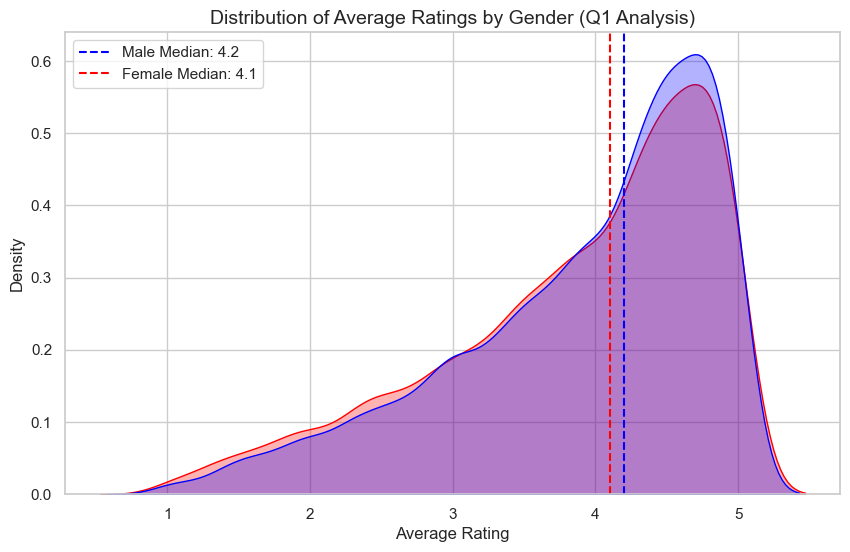

In [40]:
# 1. Perform statistical test: Mann-Whitney U test (non-parametric test)
# The Mann-Whitney U test is used to compare the distributions of two independent groups
# It tests the null hypothesis that the distributions are identical
u_stat, p_val_q1 = stats.mannwhitneyu(male_ratings, female_ratings, alternative='two-sided')
median_male = np.median(male_ratings)
median_female = np.median(female_ratings)

print(f"--- Q1 Results ---")
print(f"Male Median: {median_male}, Female Median: {median_female}")
print(f"Mann-Whitney U Statistic: {u_stat}")
print(f"P-value: {p_val_q1:.5e}")

# 2. Visualization: KDE Plot (Kernel Density Estimation plot)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_clean, x='AvgRating', hue='Gender', fill=True, common_norm=False, palette=['blue', 'red'], alpha=0.3)
plt.axvline(median_male, color='blue', linestyle='--', label=f'Male Median: {median_male}')
plt.axvline(median_female, color='red', linestyle='--', label=f'Female Median: {median_female}')

plt.title('Distribution of Average Ratings by Gender (Q1 Analysis)', fontsize=14)
plt.xlabel('Average Rating')
plt.ylabel('Density')
plt.legend()
plt.show()

Question 2

--- Q2 Results ---
KS Statistic: 0.02791
P-value: 1.24887e-03
Male Std Dev: 0.9101, Female Std Dev: 0.9497


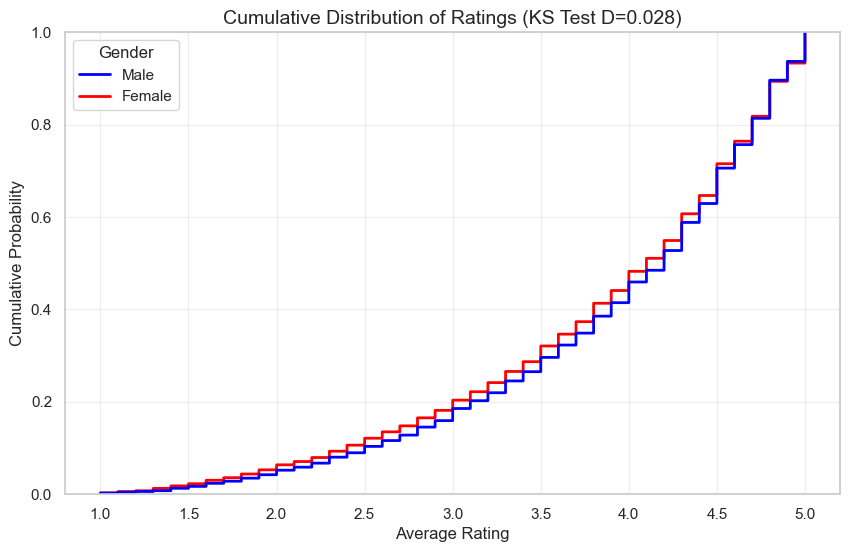

In [41]:
# 1. Perform KS Test (Kolmogorov-Smirnov test): Compare overall distributions/spread
# The Kolmogorov-Smirnov test is a non-parametric test that compares the cumulative distribution functions (CDFs) of two samples
# It tests the null hypothesis that the two samples are drawn from the same distribution
ks_stat, p_val_q2 = stats.ks_2samp(male_ratings, female_ratings)
std_male = np.std(male_ratings)
std_female = np.std(female_ratings)

print(f"--- Q2 Results ---")
print(f"KS Statistic: {ks_stat:.5f}")
print(f"P-value: {p_val_q2:.5e}")
print(f"Male Std Dev: {std_male:.4f}, Female Std Dev: {std_female:.4f}")

plt.figure(figsize=(10, 6))
sns.ecdfplot(data=df_clean, x='AvgRating', hue='Gender', palette=['blue', 'red'], linewidth=2)
plt.title(f'Cumulative Distribution of Ratings (KS Test D={ks_stat:.3f})', fontsize=14)
plt.xlabel('Average Rating')
plt.ylabel('Cumulative Probability')
plt.grid(True, alpha=0.3)
plt.show()

Question 3

--- Q3 Results ---
95% CI for Median Diff (Rating Bias): [0.0000, 0.1000]
95% CI for Std Dev Diff (Spread Bias): [-0.0586, -0.0205]


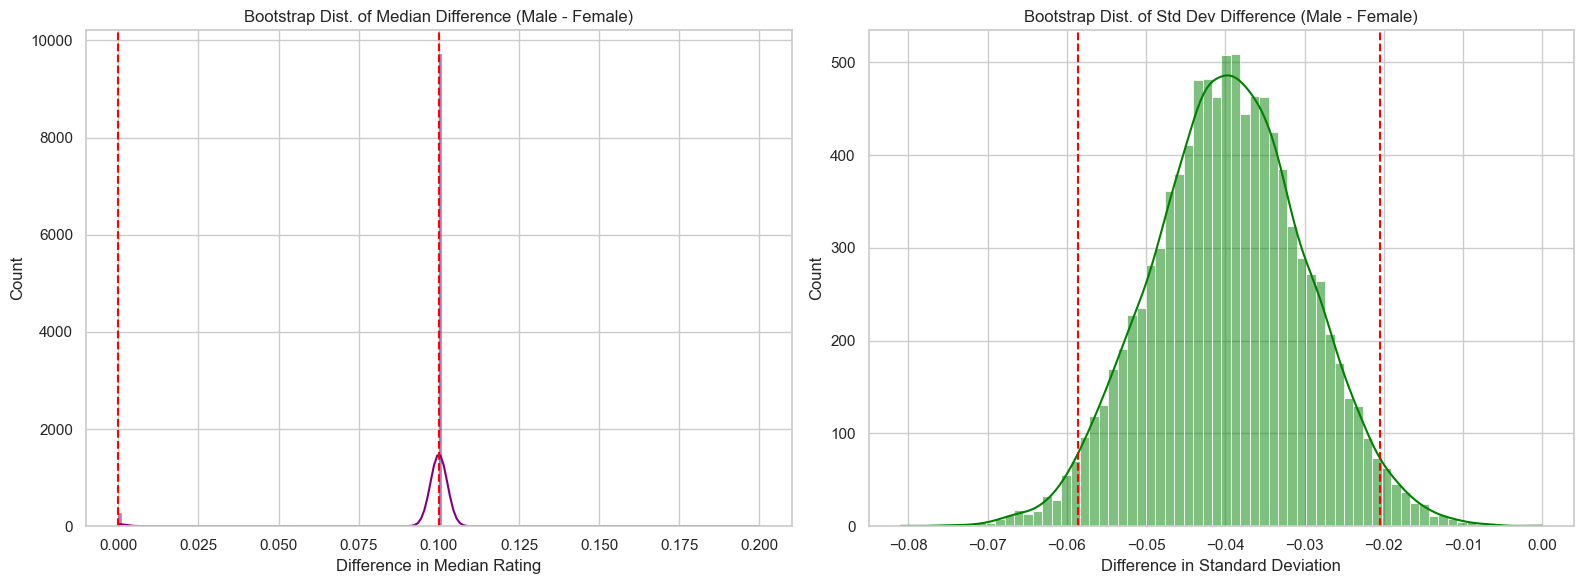

In [42]:
# Bootstrap method: A resampling technique used to estimate the sampling distribution
# of a statistic by repeatedly sampling with replacement from the observed data
# This allows us to construct confidence intervals without assuming a specific distribution

n_boot = 10000
boot_median_diffs = []
boot_std_diffs = []

# Convert to numpy array for better performance
m_data = male_ratings.values
f_data = female_ratings.values

for _ in range(n_boot):
    # Resample with replacement
    m_sample = np.random.choice(m_data, size=len(m_data), replace=True)
    f_sample = np.random.choice(f_data, size=len(f_data), replace=True)
    
    # Calculate the difference in statistics for each simulation (Male - Female)
    boot_median_diffs.append(np.median(m_sample) - np.median(f_sample)) # Corresponds to Q1
    boot_std_diffs.append(np.std(m_sample) - np.std(f_sample))       # Corresponds to Q2

# Calculate 95% confidence interval
ci_median = np.percentile(boot_median_diffs, [2.5, 97.5])
ci_std = np.percentile(boot_std_diffs, [2.5, 97.5])

print(f"--- Q3 Results ---")
print(f"95% CI for Median Diff (Rating Bias): [{ci_median[0]:.4f}, {ci_median[1]:.4f}]")
print(f"95% CI for Std Dev Diff (Spread Bias): [{ci_std[0]:.4f}, {ci_std[1]:.4f}]")

# Visualization: Bootstrapped Differences Histogram
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Median Difference
sns.histplot(boot_median_diffs, kde=True, ax=ax[0], color='purple', alpha=0.5)
ax[0].axvline(ci_median[0], color='red', linestyle='--')
ax[0].axvline(ci_median[1], color='red', linestyle='--')
ax[0].set_title('Bootstrap Dist. of Median Difference (Male - Female)')
ax[0].set_xlabel('Difference in Median Rating')

# Plot 2: Std Dev Difference
sns.histplot(boot_std_diffs, kde=True, ax=ax[1], color='green', alpha=0.5)
ax[1].axvline(ci_std[0], color='red', linestyle='--')
ax[1].axvline(ci_std[1], color='red', linestyle='--')
ax[1].set_title('Bootstrap Dist. of Std Dev Difference (Male - Female)')
ax[1].set_xlabel('Difference in Standard Deviation')

plt.tight_layout()
plt.show()

Question 4

In [43]:
# ==========================================
# Q4 Analysis Code: Chi-Square for Tags
# ==========================================
# Chi-Square test of independence: A statistical test used to determine if there is
# a significant association between two categorical variables (Gender and Tag presence)
# It tests the null hypothesis that the variables are independent

# 1. Calculate total population (for normalization)
total_ratings_male = df_clean[df_clean['Gender'] == 'Male']['NumRatings'].sum()
total_ratings_female = df_clean[df_clean['Gender'] == 'Female']['NumRatings'].sum()

# 2. Tag list
cols_tags = [
    "Tough grader", "Good feedback", "Respected", "Lots to read", "Participation matters",
    "Don't skip class", "Lots of homework", "Inspirational", "Pop quizzes!", "Accessible",
    "So many papers", "Clear grading", "Hilarious", "Test heavy", "Graded by few things",
    "Amazing lectures", "Caring", "Extra credit", "Group projects", "Lecture heavy"
]

results = []

# 3. Loop through each tag to perform the test
for tag in cols_tags:
    # Count how many times each gender received this tag
    male_count = df_clean[df_clean['Gender'] == 'Male'][tag].sum()
    female_count = df_clean[df_clean['Gender'] == 'Female'][tag].sum()
    
    # Create contingency table: [[Male with tag, Male without tag], [Female with tag, Female without tag]]
    obs = np.array([
        [male_count, total_ratings_male - male_count],
        [female_count, total_ratings_female - female_count]
    ])
    
    # Perform Chi-Square test of independence
    chi2, p_val, dof, expected = stats.chi2_contingency(obs)
    
    # Calculate frequency difference (to determine if bias is toward Male or Female)
    m_rate = male_count / total_ratings_male
    f_rate = female_count / total_ratings_female
    diff = m_rate - f_rate  # Positive value = Male bias, Negative value = Female bias
    
    results.append({
        'Tag': tag,
        'P-value': p_val,
        'Diff': diff,
        'Bias': 'Male' if diff > 0 else 'Female'
    })

# 4. Convert to DataFrame and sort by P-value
df_res = pd.DataFrame(results).sort_values(by='P-value')

print("\nTop 3 Most Gendered (Lowest P-value):")
print(df_res.head(3)[['Tag', 'P-value', 'Bias']])

print("\nTop 3 Least Gendered (Highest P-value):")
print(df_res.tail(3)[['Tag', 'P-value', 'Bias']])


Top 3 Most Gendered (Lowest P-value):
                 Tag        P-value    Bias
12         Hilarious   0.000000e+00    Male
15  Amazing lectures  1.617131e-120    Male
16            Caring   4.352662e-85  Female

Top 3 Least Gendered (Highest P-value):
              Tag       P-value    Bias
11  Clear grading  4.932932e-10  Female
9      Accessible  5.942501e-09    Male
8    Pop quizzes!  4.731195e-01    Male


Question 5: Is there a gender difference in terms of average difficulty? Again, a significance test is indicate

In [44]:
num.describe()

,Avg_Rating,Avg_Difficulty,NumofRatings,Pepper,Again?,From online,Male,Female
count,70004.000000,70004.000000,70004.000000,70004.000000,12160.000000,70004.000000,89893.000000,89893.000000
mean,3.808014,2.864623,5.374721,0.279927,76.417105,0.315611,0.326789,0.301903
std,1.126895,0.991064,8.136628,0.448966,25.011441,1.054728,0.469042,0.459086
min,1.000000,1.000000,1.000000,0.000000,4.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000,1.000000,0.000000,60.000000,0.000000,0.000000,0.000000
50%,4.000000,3.000000,3.000000,0.000000,83.000000,0.000000,0.000000,0.000000
75%,4.800000,3.500000,6.000000,1.000000,100.000000,0.000000,1.000000,1.000000
max,5.000000,5.000000,393.000000,1.000000,100.000000,19.000000,1.000000,1.000000


In [10]:
num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89893 entries, 0 to 89892
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Avg_Rating      70004 non-null  float64
 1   Avg_Difficulty  70004 non-null  float64
 2   NumofRatings    70004 non-null  float64
 3   Pepper          70004 non-null  float64
 4   Again?          12160 non-null  float64
 5   From online     70004 non-null  float64
 6   Male            89893 non-null  int64  
 7   Female          89893 non-null  int64  
dtypes: float64(6), int64(2)
memory usage: 5.5 MB


In [45]:
# Combine two gender columns into one
num['Gender'] = num['Male'] + num['Female'] * -1
num['Gender'] = num['Gender'].astype(int)

In [46]:
# Replace 0 values with NaN in Gender column
num['Gender'] = num['Gender'].replace(0, pd.NA)
num['Gender'] = num['Gender'].replace(2, pd.NA)

# Drop null values in Avg_Difficulty
num = num.dropna(subset=['Avg_Difficulty', 'Gender'])

In [47]:
# Take Mann-Whitney U test to test if there is a significant difference in Avg_Difficulty between male and female professors

# Use all data
male_difficulty = num.loc[num['Gender'] == 1, 'Avg_Difficulty']
female_difficulty = num.loc[num['Gender'] == -1, 'Avg_Difficulty']

stat, p = mannwhitneyu(male_difficulty, female_difficulty, alternative='two-sided')
print("Using all data:")
print(f"Mann-Whitney U test statistic: {stat}, p-value: {p}")

# Use data which has at least 2 ratings, since the last 25% of data has 2 rating
male_difficulty = num.loc[(num['Gender'] == 1) & (num['NumofRatings'] >= 2), 'Avg_Difficulty']
female_difficulty = num.loc[(num['Gender'] == -1) & (num['NumofRatings'] >= 2), 'Avg_Difficulty']

stat, p = mannwhitneyu(male_difficulty, female_difficulty, alternative='two-sided')
print("Using data with at least 2 ratings:")
print(f"Mann-Whitney U test statistic: {stat}, p-value: {p}")

# Use data which has at least 3 ratings, since the last 50% of data has less than 3 ratings
male_difficulty = num.loc[(num['Gender'] == 1) & (num['NumofRatings'] >= 3), 'Avg_Difficulty']
female_difficulty = num.loc[(num['Gender'] == -1) & (num['NumofRatings'] >= 3), 'Avg_Difficulty']

stat, p = mannwhitneyu(male_difficulty, female_difficulty, alternative='two-sided')
print("Using data with at least 3 ratings:")
print(f"Mann-Whitney U test statistic: {stat}, p-value: {p}")

# Use data which has at least 6 ratings, since the last 75% of data has less than 6 ratings
male_difficulty = num.loc[(num['Gender'] == 1) & (num['NumofRatings'] >= 6), 'Avg_Difficulty']
female_difficulty = num.loc[(num['Gender'] == -1) & (num['NumofRatings'] >= 6), 'Avg_Difficulty']

stat, p = mannwhitneyu(male_difficulty, female_difficulty, alternative='two-sided')
print("Using data with at least 6 ratings:")
print(f"Mann-Whitney U test statistic: {stat}, p-value: {p}")

# Use data which has at least 10 ratings
male_difficulty = num.loc[(num['Gender'] == 1) & (num['NumofRatings'] >= 10), 'Avg_Difficulty']
female_difficulty = num.loc[(num['Gender'] == -1) & (num['NumofRatings'] >= 10), 'Avg_Difficulty']

stat, p = mannwhitneyu(male_difficulty, female_difficulty, alternative='two-sided')
print("Using data with at least 10 ratings:")
print(f"Mann-Whitney U test statistic: {stat}, p-value: {p}")

Using all data:
Mann-Whitney U test statistic: 337740081.0, p-value: 0.6427861627773832
Using data with at least 2 ratings:
Mann-Whitney U test statistic: 185788757.5, p-value: 0.8936314303305133
Using data with at least 3 ratings:
Mann-Whitney U test statistic: 110265126.0, p-value: 0.7339757984597012
Using data with at least 6 ratings:
Mann-Whitney U test statistic: 27435669.0, p-value: 0.9680622117890496
Using data with at least 10 ratings:
Mann-Whitney U test statistic: 6192402.0, p-value: 0.7855271637343776


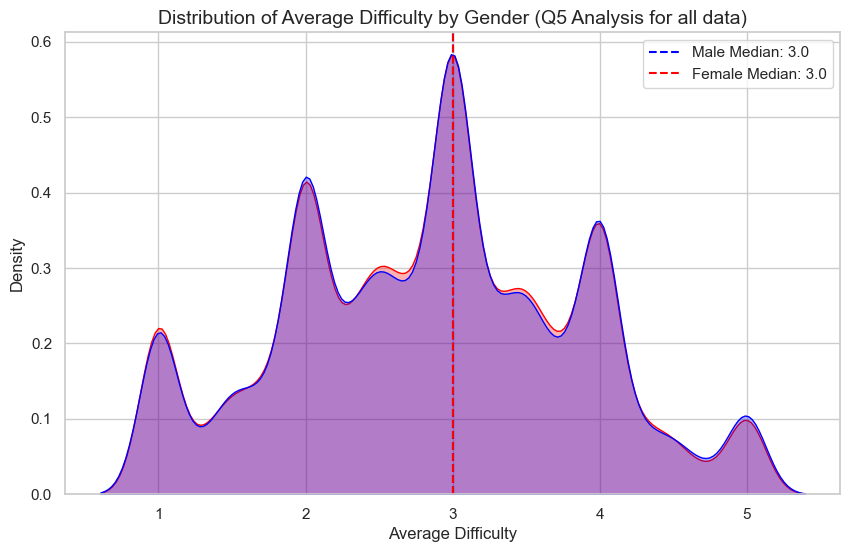

In [53]:
# Visualization: KDE Plot (Kernel Density Estimation plot)
male_median = np.median(num[num['Gender'] == 1]['Avg_Difficulty'])
female_median = np.median(num[num['Gender'] == -1]['Avg_Difficulty'])

plt.figure(figsize=(10, 6))
sns.kdeplot(data=num, x='Avg_Difficulty', hue='Gender', fill=True, common_norm=False, palette=['blue', 'red'], alpha=0.3)
plt.axvline(male_median, color='blue', linestyle='--', label=f'Male Median: {male_median}')
plt.axvline(female_median, color='red', linestyle='--', label=f'Female Median: {female_median}')

plt.title('Distribution of Average Difficulty by Gender (Q5 Analysis for all data)', fontsize=14)
plt.xlabel('Average Difficulty')
plt.ylabel('Density')
plt.legend()
plt.show()

Question 6: Please quantify the likely size of this effect at 95% confidence

In [54]:
def bootstrap_effect_size(num, threshold):
    # Prepare data for Bootstrap
    male_data = num.loc[(num['Gender'] == 1) & (num['NumofRatings'] >= threshold), 'Avg_Difficulty'].values
    female_data = num.loc[(num['Gender'] == -1) & (num['NumofRatings'] >= threshold), 'Avg_Difficulty'].values

    # Calculate the observed effect size
    actual_diff = np.mean(male_data) - np.mean(female_data)

    # Bootstrap process
    n_boot = 10000
    boot_diffs = []

    for _ in range(n_boot):
        # Resample with replacement
        male_sample = rng.choice(male_data, size=len(male_data), replace=True)
        female_sample = rng.choice(female_data, size=len(female_data), replace=True)

        # Calculate the difference for this bootstrap sample
        diff = np.mean(male_sample) - np.mean(female_sample)
        boot_diffs.append(diff)

    # Convert to array
    boot_diffs = np.array(boot_diffs)

    # Calculate 95% confidence interval
    ci_lower = np.percentile(boot_diffs, 2.5)
    ci_upper = np.percentile(boot_diffs, 97.5)

    print(f"Effect Size: {actual_diff:.4f}")
    print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

In [55]:
for threshold in [1, 2, 3, 6, 10]:
    print(f"\nBootstrap Effect Size for NumofRatings >= {threshold}:")
    bootstrap_effect_size(num, threshold)


Bootstrap Effect Size for NumofRatings >= 1:
Effect Size: -0.0056
95% Confidence Interval: [-0.0230, 0.0112]

Bootstrap Effect Size for NumofRatings >= 2:
Effect Size: -0.0028
95% Confidence Interval: [-0.0209, 0.0153]

Bootstrap Effect Size for NumofRatings >= 3:
Effect Size: 0.0014
95% Confidence Interval: [-0.0183, 0.0208]

Bootstrap Effect Size for NumofRatings >= 6:
Effect Size: -0.0012
95% Confidence Interval: [-0.0266, 0.0241]

Bootstrap Effect Size for NumofRatings >= 10:
Effect Size: -0.0070
95% Confidence Interval: [-0.0441, 0.0286]


Effect Size: -0.0056
95% Confidence Interval: [-0.0227, 0.0117]


Text(0.5, 0, 'Difference in Mean Difficulty (Male - Female)')

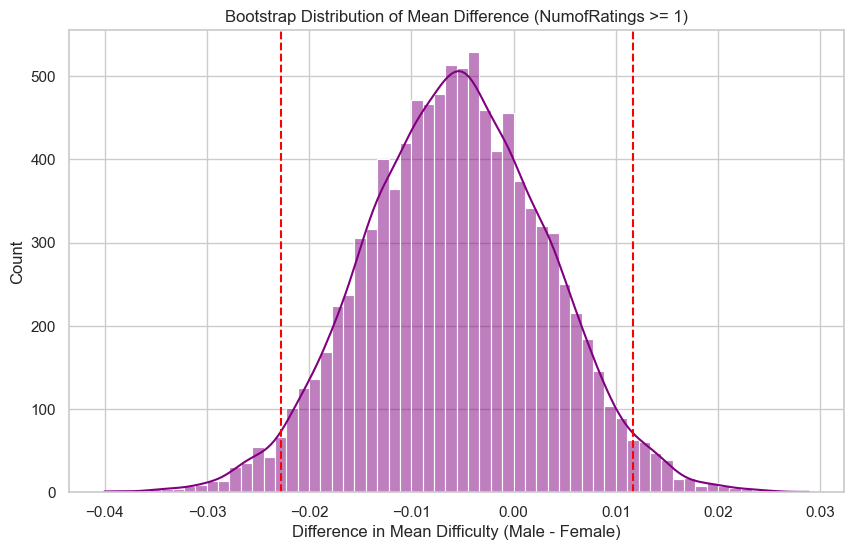

In [58]:
# Prepare data for Bootstrap
male_data = num.loc[(num['Gender'] == 1) & (num['NumofRatings'] >= 1), 'Avg_Difficulty'].values
female_data = num.loc[(num['Gender'] == -1) & (num['NumofRatings'] >= 1), 'Avg_Difficulty'].values

# Calculate the observed effect size
actual_diff = np.mean(male_data) - np.mean(female_data)

# Bootstrap process
n_boot = 10000
boot_diffs = []

for _ in range(n_boot):
    # Resample with replacement
    male_sample = rng.choice(male_data, size=len(male_data), replace=True)
    female_sample = rng.choice(female_data, size=len(female_data), replace=True)

    # Calculate the difference for this bootstrap sample
    diff = np.mean(male_sample) - np.mean(female_sample)
    boot_diffs.append(diff)

# Convert to array
boot_diffs = np.array(boot_diffs)

# Calculate 95% confidence interval
ci_lower = np.percentile(boot_diffs, 2.5)
ci_upper = np.percentile(boot_diffs, 97.5)

print(f"Effect Size: {actual_diff:.4f}")
print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

# Visualization: Bootstrapped Differences Histogram
plt.figure(figsize=(10, 6))
sns.histplot(boot_diffs, kde=True, color='purple', alpha=0.5)
plt.axvline(ci_lower, color='red', linestyle='--', label='95% CI Lower Bound')
plt.axvline(ci_upper, color='red', linestyle='--', label='95% CI Upper Bound')
plt.title(f'Bootstrap Distribution of Mean Difference (NumofRatings >= 1)')
plt.xlabel('Difference in Mean Difficulty (Male - Female)') 

Question 7: Build a regression model predicting average rating from all numerical predictors (the ones in the
rmpCapstoneNum.csv) file. Make sure to include the R2 and RMSE of this model. Which of these
factors is most strongly predictive of average rating? Hint: Make sure to address collinearity concerns.


Multicollinearity Analysis:
Found 3 feature pairs with |r| > 0.8

Top 10 most correlated feature pairs:
  Feature 1 Feature 2  Correlation
2    Female    Gender         -1.0
0      Male    Female         -1.0
1      Male    Gender          1.0


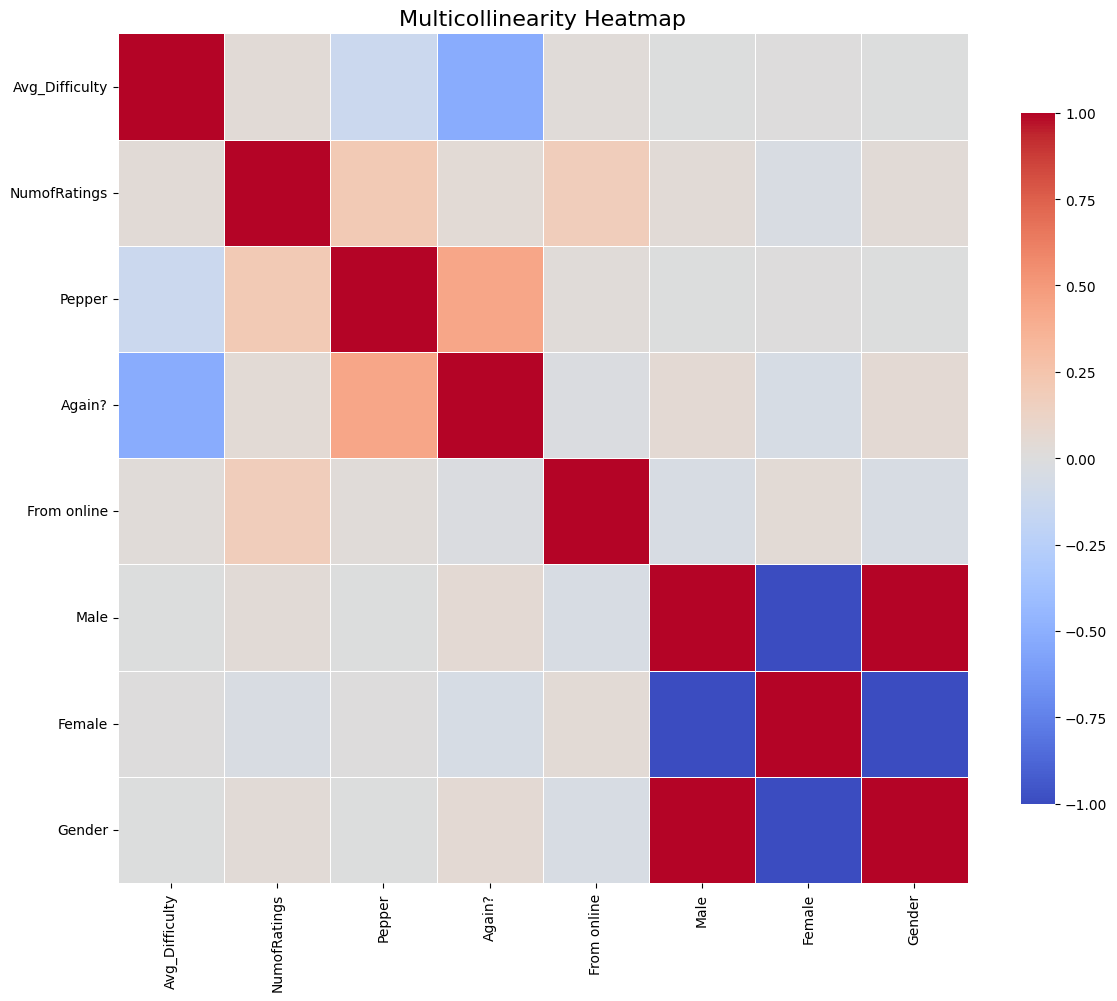

In [16]:
# We will check for multicollinearity among the features by calculating the correlation matrix, only correlation of the gender features are higher than 0.8
# Mulicolinearity
# --- Check for Multicollinearity ---
# Select only the features (exclude target)
features_for_collinearity = num.drop(columns=['Avg_Rating'])

# Calculate correlation matrix among features, add labels
feature_corr_matrix = features_for_collinearity.corr()

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(feature_corr_matrix.columns)):
    for j in range(i+1, len(feature_corr_matrix.columns)):
        if abs(feature_corr_matrix.iloc[i, j]) > 0.8:  # threshold for high correlation
            high_corr_pairs.append({
                'Feature 1': feature_corr_matrix.columns[i],
                'Feature 2': feature_corr_matrix.columns[j],
                'Correlation': feature_corr_matrix.iloc[i, j]
            })

print("\nMulticollinearity Analysis:")
print("=" * 60)
print(f"Found {len(high_corr_pairs)} feature pairs with |r| > 0.8")

if len(high_corr_pairs) > 0:
    print("\nTop 10 most correlated feature pairs:")
    high_corr_df = pd.DataFrame(high_corr_pairs)
    high_corr_df = high_corr_df.sort_values('Correlation', key=abs, ascending=False)
    print(high_corr_df.head(10))

# Create heatmap for a subset of features
plt.figure(figsize=(12, 10))
sns.heatmap(feature_corr_matrix, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Multicollinearity Heatmap', fontsize=16)
plt.tight_layout()
plt.show()


In [17]:
# Define features and target variable
# Since feature male, female, and gender are collinear, we only keep gender
predictors = ['Avg_Difficulty', 'NumofRatings', 'Pepper', 'Again?', 'From online', 'Gender']
target = 'Avg_Rating'

# Drop null values in predictors and target
regression_data = num[predictors + [target]].dropna()

print(f"Original: {len(num)}")
print(f"After removing null values: {len(regression_data)}")

# Define X and y
X = regression_data[predictors]
y = regression_data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=MY_SEED)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Transform arrays back to DataFrames for statsmodels
X_train_scaled = pd.DataFrame(X_train_scaled, columns=predictors, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=predictors, index=X_test.index)

# Add constant term for intercept
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Fit the regression model
model = sm.OLS(y_train, X_train_scaled).fit()

# Print the summary of the regression model
print(model.summary())

# Calculate RMSE on the test set
y_pred = model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.4f}")
print("Model R-squared on training set:", model.rsquared)

r2_score = r2_score(y_test, y_pred)
print("Model R-squared on test set:", r2_score)

# Find the coefficients for Avg_Difficulty
params = model.params.drop('const')
max_impact_feature = params.abs().idxmax()
max_impact_value = params[max_impact_feature]

print(f"The feature with the highest impact on Avg_Rating is '{max_impact_feature}' with a coefficient of {max_impact_value:.4f}.")

Original: 52089
After removing null values: 8849
                            OLS Regression Results                            
Dep. Variable:             Avg_Rating   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     5006.
Date:                Thu, 18 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:58:55   Log-Likelihood:                -2931.1
No. Observations:                7079   AIC:                             5876.
Df Residuals:                    7072   BIC:                             5924.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

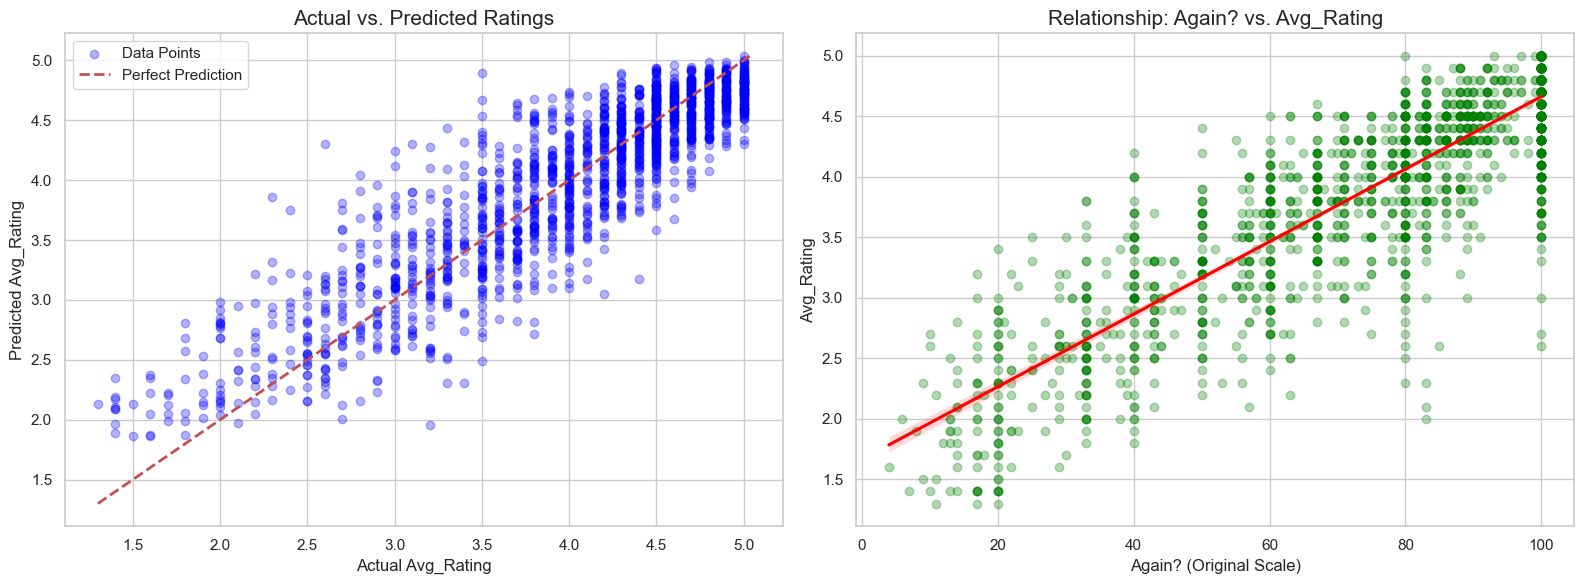

In [18]:
# Set seaborn style
sns.set(style="whitegrid")

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: Predicted vs Actual Ratings (Model Accuracy) ---
axes[0].scatter(y_test, y_pred, alpha=0.3, color='blue', label='Data Points')

# Draw a red 45-degree line (perfect prediction line)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

axes[0].set_title('Actual vs. Predicted Ratings', fontsize=15)
axes[0].set_xlabel('Actual Avg_Rating', fontsize=12)
axes[0].set_ylabel('Predicted Avg_Rating', fontsize=12)
axes[0].legend()


# --- Plot 2: Strongest Predictor vs. Ratings (Visualizing Trends) ---
strongest_factor = 'Again?'

# To draw this plot, we use the original, unstandardized data (regression_data) for better readability
plot_sample = regression_data.sample(n=min(2000, len(regression_data)), random_state=42)

sns.regplot(
    x=strongest_factor, 
    y='Avg_Rating', 
    data=plot_sample, 
    ax=axes[1], 
    scatter_kws={'alpha':0.3, 'color':'green'}, 
    line_kws={'color':'red'} 
)

axes[1].set_title(f'Relationship: {strongest_factor} vs. Avg_Rating', fontsize=15)
axes[1].set_xlabel(f'{strongest_factor} (Original Scale)', fontsize=12)
axes[1].set_ylabel('Avg_Rating', fontsize=12)

plt.tight_layout()
plt.show()

Bonus: Are the rating of professors in New York state different from those in other states?

In [19]:
# Read the CSV file
num = pd.read_csv("rmpCapstoneNum.csv", header=None)
qual = pd.read_csv("rmpCapstoneQual.csv", header=None)

In [20]:
# Rename columns of qual for better readability
num.columns = ['Avg_Rating', 'Avg_Difficulty', 'NumofRatings', 'Pepper', 'Again?', 'From online', 'Male', 'Female']
qual.columns = ['Field', 'University', 'US State']
qual.head()

,Field,University,US State
0,Criminal Justice,George Mason University,VA
1,NaN,NaN,NaN
2,English,Alabama State University,AL
3,English,University of Kentucky,KY
4,English,Keiser University,FL


In [21]:
qual[qual['US State'] == 'NY']

,Field,University,US State
29,Environment,SUNY Potsdam,NY
33,Mathematics,Medgar Evers College,NY
36,Marketing,Berkeley College,NY
38,Mathematics,Borough of Manhattan Community College,NY
63,English,Baruch College,NY
...,...,...,...
89793,English,SUNY New Paltz,NY
89829,Mathematics,Monroe Community College,NY
89856,Psychology,Long Island University,NY
89867,Education,Long Island University,NY


In [22]:
# Merge num and qual dataframes by index
merged_data = num.merge(qual, left_index=True, right_index=True)
merged_data.head()

,Avg_Rating,Avg_Difficulty,NumofRatings,Pepper,Again?,From online,Male,Female,Field,University,US State
0,5.0,1.5,2.0,0.0,NaN,0.0,0,1,Criminal Justice,George Mason University,VA
1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN
2,3.2,3.0,4.0,0.0,NaN,0.0,1,0,English,Alabama State University,AL
3,3.6,3.5,10.0,1.0,NaN,0.0,0,0,English,University of Kentucky,KY
4,1.0,5.0,1.0,0.0,NaN,0.0,0,0,English,Keiser University,FL


In [23]:
# Drop null values in Avg_Rating, US State
merged_data = merged_data.dropna(subset=['Avg_Rating', 'US State'])

In [24]:
# Take Mann-Whitney U test to test if there is a significant difference in Avg_Rating between different states

# Use all data
ny_ratings = merged_data.loc[merged_data['US State'] == 'NY', 'Avg_Rating']
other_ratings = merged_data.loc[merged_data['US State'] != 'NY', 'Avg_Rating']

stat, p = mannwhitneyu(ny_ratings, other_ratings, alternative='two-sided')
print("Using all data:")
print(f"Mann-Whitney U test statistic: {stat}, p-value: {p}")

# Use data which has at least 2 ratings, since the last 25% of data has 1 rating
ny_ratings = merged_data.loc[(merged_data['US State'] == 'NY') & (merged_data['NumofRatings'] >= 2), 'Avg_Rating']
other_ratings = merged_data.loc[(merged_data['US State'] != 'NY') & (merged_data['NumofRatings'] >= 2), 'Avg_Rating']

stat, p = mannwhitneyu(ny_ratings, other_ratings, alternative='two-sided')
print("Using data with at least 2 ratings:")
print(f"Mann-Whitney U test statistic: {stat}, p-value: {p}")

# Use data which has at least 3 ratings, since the last 50% of data has less than 3 ratings
ny_ratings = merged_data.loc[(merged_data['US State'] == 'NY') & (merged_data['NumofRatings'] >= 3), 'Avg_Rating']
other_ratings = merged_data.loc[(merged_data['US State'] != 'NY') & (merged_data['NumofRatings'] >= 3), 'Avg_Rating']

stat, p = mannwhitneyu(ny_ratings, other_ratings, alternative='two-sided')
print("Using data with at least 3 ratings:")
print(f"Mann-Whitney U test statistic: {stat}, p-value: {p}")

# Use data which has at least 6 ratings, since the last 75% of data has less than 6 ratings
ny_ratings = merged_data.loc[(merged_data['US State'] == 'NY') & (merged_data['NumofRatings'] >= 6), 'Avg_Rating']
other_ratings = merged_data.loc[(merged_data['US State'] != 'NY') & (merged_data['NumofRatings'] >= 6), 'Avg_Rating']

stat, p = mannwhitneyu(ny_ratings, other_ratings, alternative='two-sided')
print("Using data with at least 6 ratings:")
print(f"Mann-Whitney U test statistic: {stat}, p-value: {p}")

# Use data which has at least 10 ratings
ny_ratings = merged_data.loc[(merged_data['US State'] == 'NY') & (merged_data['NumofRatings'] >= 10), 'Avg_Rating']
other_ratings = merged_data.loc[(merged_data['US State'] != 'NY') & (merged_data['NumofRatings'] >= 10), 'Avg_Rating']

stat, p = mannwhitneyu(ny_ratings, other_ratings, alternative='two-sided')
print("Using data with at least 10 ratings:")
print(f"Mann-Whitney U test statistic: {stat}, p-value: {p}")

Using all data:
Mann-Whitney U test statistic: 168627337.5, p-value: 0.1464846283926016
Using data with at least 2 ratings:
Mann-Whitney U test statistic: 96911760.0, p-value: 0.02494421782976642
Using data with at least 3 ratings:
Mann-Whitney U test statistic: 57806598.0, p-value: 0.2681091399412635
Using data with at least 6 ratings:
Mann-Whitney U test statistic: 14935670.0, p-value: 0.1512814169941711
Using data with at least 10 ratings:
Mann-Whitney U test statistic: 3016390.5, p-value: 0.27092093078556345


/var/folders/3c/kxfpvzq56558my2fcggnzrn40000gn/T/ipykernel_32658/107112912.py:6: UserWarning: 
The palette list has fewer values (2) than needed (89) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(data=merged_data, x='Avg_Rating', hue='US State', fill=True, common_norm=False, palette=['blue', 'red'], alpha=0.3)
/var/folders/3c/kxfpvzq56558my2fcggnzrn40000gn/T/ipykernel_32658/107112912.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=merged_data, x='Avg_Rating', hue='US State', fill=True, common_norm=False, palette=['blue', 'red'], alpha=0.3)


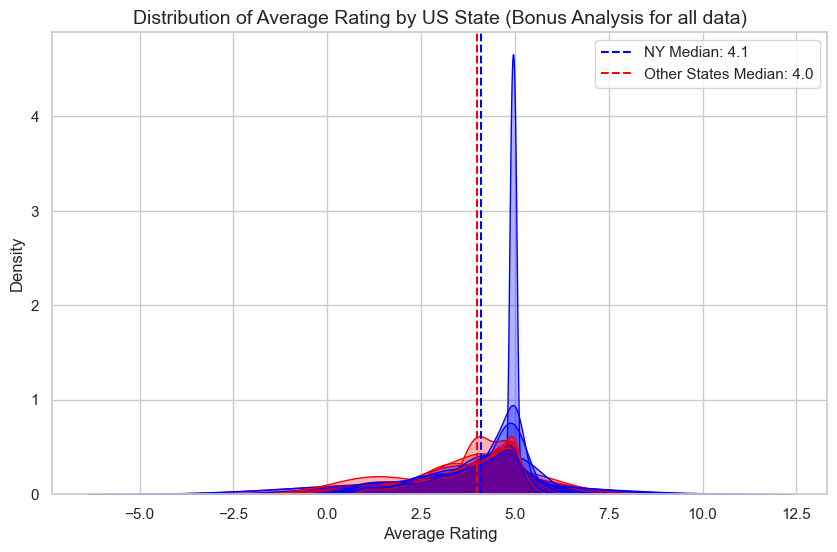

In [59]:
# Visualization: KDE Plot (Kernel Density Estimation plot)
ny_ratings = np.median(merged_data.loc[merged_data['US State'] == 'NY', 'Avg_Rating'])
other_ratings = np.median(merged_data.loc[merged_data['US State'] != 'NY', 'Avg_Rating'])

plt.figure(figsize=(10, 6))
sns.kdeplot(data=merged_data, x='Avg_Rating', hue='US State', fill=True, common_norm=False, palette=['blue', 'red'], alpha=0.3)
plt.axvline(ny_ratings, color='blue', linestyle='--', label=f'NY Median: {ny_ratings}')
plt.axvline(other_ratings, color='red', linestyle='--', label=f'Other States Median: {other_ratings}')

plt.title('Distribution of Average Rating by US State (Bonus Analysis for all data)', fontsize=14)
plt.xlabel('Average Rating')
plt.ylabel('Density')
plt.legend()
plt.show()

Question8: Build a regression model predicting average ratings from all tags (the ones in the rmpCapstoneTags.csv) file. Make sure to include the R2 and RMSE of this model. Which of these tags is most strongly predictive of average rating? Hint: Make sure to address collinearity concerns. Also comment on how this model compares to the previous one.


In [25]:
# Load tags data
tags = pd.read_csv("rmpCapstoneTags.csv", header=None)

# Define tag column names
tag_names = [
    'Tough_grader', 'Good_feedback', 'Respected', 'Lots_to_read', 'Participation_matters',
    'Dont_skip_class', 'Lots_of_homework', 'Inspirational', 'Pop_quizzes', 'Accessible',
    'So_many_papers', 'Clear_grading', 'Hilarious', 'Test_heavy', 'Graded_by_few_things',
    'Amazing_lectures', 'Caring', 'Extra_credit', 'Group_projects', 'Lecture_heavy'
]

tags.columns = tag_names
print(f"Tags data shape: {tags.shape}")
tags.head()


Tags data shape: (89893, 20)


,Tough_grader,Good_feedback,Respected,Lots_to_read,Participation_matters,Dont_skip_class,Lots_of_homework,Inspirational,Pop_quizzes,Accessible,So_many_papers,Clear_grading,Hilarious,Test_heavy,Graded_by_few_things,Amazing_lectures,Caring,Extra_credit,Group_projects,Lecture_heavy
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,1,2,1,0,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,3,0,0,2,4,2,1,0,0,0,2,1,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
# Reload num data to ensure we have the full dataset
num_full = pd.read_csv("rmpCapstoneNum.csv", header=None)
num_full.columns = ['Avg_Rating', 'Avg_Difficulty', 'NumofRatings', 'Pepper', 'Again?', 'From online', 'Male', 'Female']

# Merge tags with numerical data by index
tags_num = tags.merge(num_full[['Avg_Rating', 'NumofRatings']], left_index=True, right_index=True)

# IMPORTANT: Handle average rating reliability based on number of ratings
# Average ratings based on more ratings are more reliable
# We will set a threshold: only use professors with at least 3 ratings
# This is a judgment call - we choose 3 as a reasonable minimum
MIN_RATINGS_THRESHOLD = 3
print(f"Setting minimum ratings threshold: {MIN_RATINGS_THRESHOLD}")
print(f"Data before filtering: {len(tags_num)}")
tags_num = tags_num[tags_num['NumofRatings'] >= MIN_RATINGS_THRESHOLD]
print(f"Data after filtering (>= {MIN_RATINGS_THRESHOLD} ratings): {len(tags_num)}")

# Normalize tags by number of ratings
# Since tags are raw counts and professors with more ratings will have more tags,
# we normalize by dividing by the number of ratings (or use proportion)
# We'll use proportion: tag_count / num_ratings
# But we need to handle cases where num_ratings is 0 or NaN

# Create normalized tag columns
for tag in tag_names:
    # Normalize: tag count per rating (proportion)
    # If a student can award up to 3 tags, max tags per rating = 3
    tags_num[f'{tag}_norm'] = tags_num[tag] / tags_num['NumofRatings'].replace(0, np.nan)

print("\nSample of normalized tags:")
tags_num[['Avg_Rating', 'NumofRatings'] + tag_names[:5] + [f'{tag}_norm' for tag in tag_names[:5]]].head()


Setting minimum ratings threshold: 3
Data before filtering: 89893
Data after filtering (>= 3 ratings): 40528

Sample of normalized tags:


,Avg_Rating,NumofRatings,Tough_grader,Good_feedback,Respected,Lots_to_read,Participation_matters,Tough_grader_norm,Good_feedback_norm,Respected_norm,Lots_to_read_norm,Participation_matters_norm
2,3.2,4.0,2,1,2,1,0,0.500000,0.250000,0.500000,0.250000,0.000000
3,3.6,10.0,6,3,0,0,2,0.600000,0.300000,0.000000,0.000000,0.200000
5,3.5,22.0,8,13,1,3,2,0.363636,0.590909,0.045455,0.136364,0.090909
8,2.6,4.0,1,1,0,0,0,0.250000,0.250000,0.000000,0.000000,0.000000
18,4.2,3.0,0,2,0,0,1,0.000000,0.666667,0.000000,0.000000,0.333333


Original data: 40528
After removing null values: 40528
Note: Only using professors with >= 3 ratings for reliability

Found 0 tag pairs with |r| > 0.8


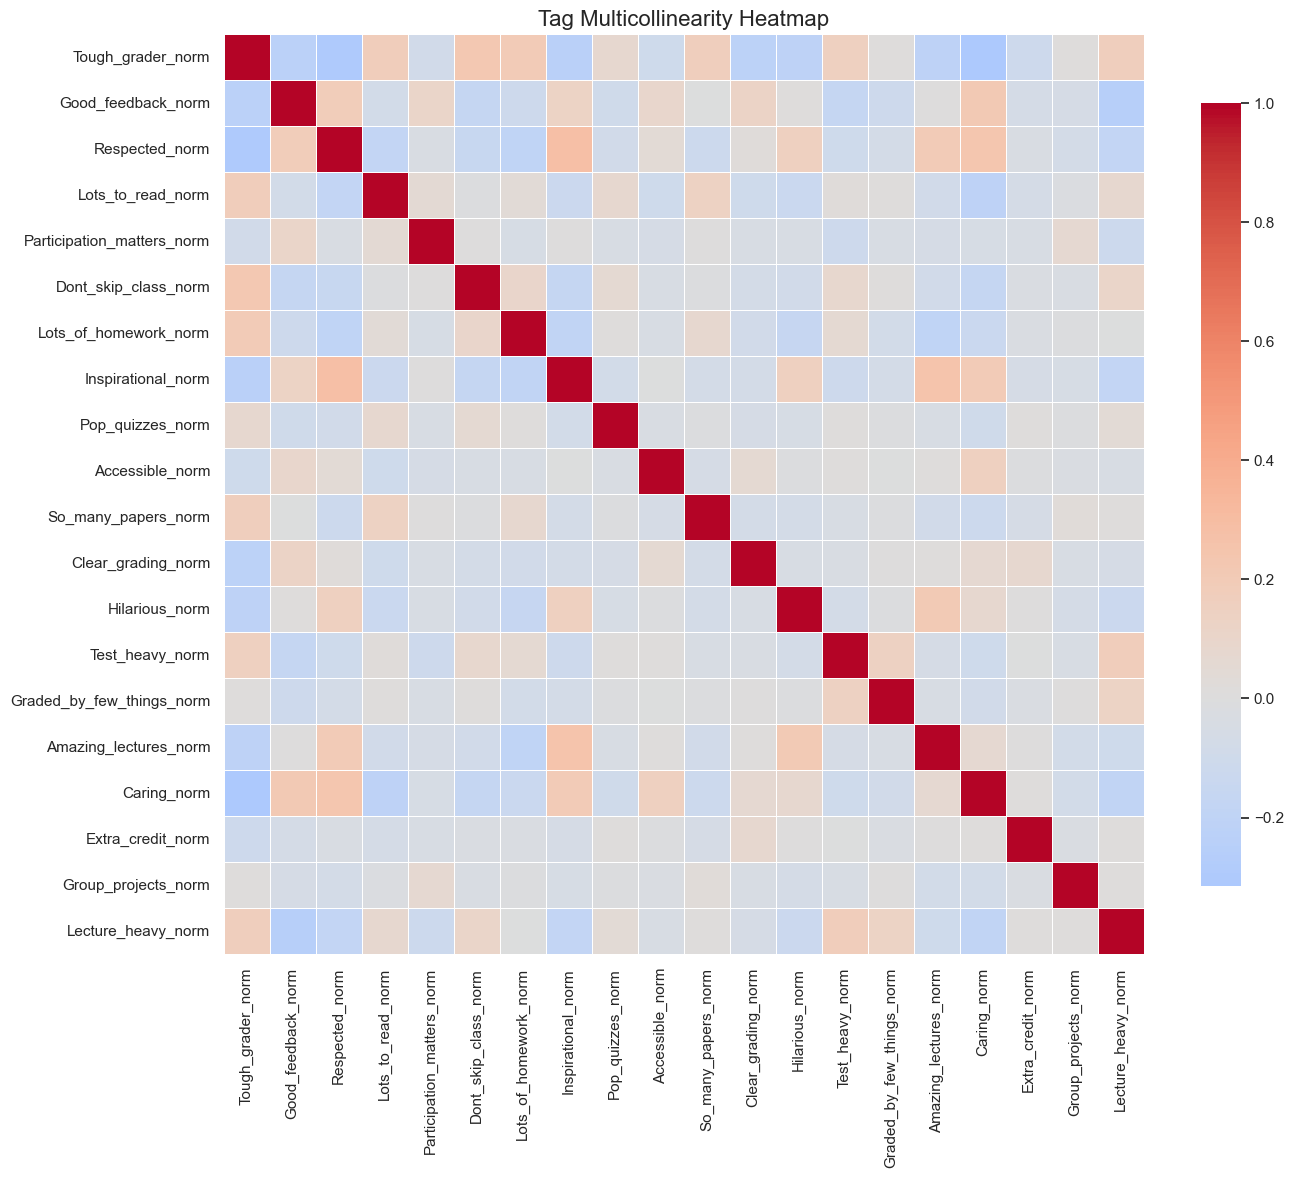

In [27]:
# Prepare data for regression
# Use normalized tags as predictors
tag_predictors = [f'{tag}_norm' for tag in tag_names]
target = 'Avg_Rating'

# Drop rows with missing values in target or any predictor
# Keep NumofRatings for potential weighting
regression_data_tags = tags_num[tag_predictors + [target, 'NumofRatings']].dropna()

print(f"Original data: {len(tags_num)}")
print(f"After removing null values: {len(regression_data_tags)}")
print(f"Note: Only using professors with >= {MIN_RATINGS_THRESHOLD} ratings for reliability")

# Check for multicollinearity among tags
tag_corr_matrix = regression_data_tags[tag_predictors].corr()

# Find highly correlated tag pairs
high_corr_pairs = []
for i in range(len(tag_corr_matrix.columns)):
    for j in range(i+1, len(tag_corr_matrix.columns)):
        if abs(tag_corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append({
                'Tag 1': tag_corr_matrix.columns[i],
                'Tag 2': tag_corr_matrix.columns[j],
                'Correlation': tag_corr_matrix.iloc[i, j]
            })

print(f"\nFound {len(high_corr_pairs)} tag pairs with |r| > 0.8")
if len(high_corr_pairs) > 0:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    high_corr_df = high_corr_df.sort_values('Correlation', key=abs, ascending=False)
    print(high_corr_df.head(10))

# Visualize correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(tag_corr_matrix, cmap='coolwarm', center=0, square=True, 
            linewidths=0.5, cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.title('Tag Multicollinearity Heatmap', fontsize=16)
plt.tight_layout()
plt.show()


In [28]:
# Build regression model
X_tags = regression_data_tags[tag_predictors]
y_tags = regression_data_tags[target]

# Split data
X_train_tags, X_test_tags, y_train_tags, y_test_tags = train_test_split(
    X_tags, y_tags, test_size=0.2, random_state=MY_SEED
)

# Standardize features
scaler_tags = StandardScaler()
X_train_tags_scaled = scaler_tags.fit_transform(X_train_tags)
X_test_tags_scaled = scaler_tags.transform(X_test_tags)

# Convert back to DataFrame
X_train_tags_scaled = pd.DataFrame(X_train_tags_scaled, columns=tag_predictors, index=X_train_tags.index)
X_test_tags_scaled = pd.DataFrame(X_test_tags_scaled, columns=tag_predictors, index=X_test_tags.index)

# Add constant
X_train_tags_scaled = sm.add_constant(X_train_tags_scaled)
X_test_tags_scaled = sm.add_constant(X_test_tags_scaled)

# Fit OLS model
model_tags = sm.OLS(y_train_tags, X_train_tags_scaled).fit()

# Print summary
print(model_tags.summary())

# Calculate RMSE and R² on test set
from sklearn.metrics import r2_score
y_pred_tags = model_tags.predict(X_test_tags_scaled)
rmse_tags = np.sqrt(mean_squared_error(y_test_tags, y_pred_tags))
r2_test_tags = r2_score(y_test_tags, y_pred_tags)
print(f"\nTest RMSE: {rmse_tags:.4f}")
print(f"Test R-squared: {r2_test_tags:.4f}")
print(f"Training R-squared: {model_tags.rsquared:.4f}")

# Find most predictive tag and check significance (α = 0.005)
ALPHA = 0.005
params_tags = model_tags.params.drop('const')
pvalues_tags = model_tags.pvalues.drop('const')

# Find significant tags
significant_tags = pvalues_tags[pvalues_tags < ALPHA]
print(f"\nSignificant tags (p < {ALPHA}): {len(significant_tags)} out of {len(params_tags)}")

max_impact_tag = params_tags.abs().idxmax()
max_impact_value = params_tags[max_impact_tag]
max_impact_pvalue = pvalues_tags[max_impact_tag]

print(f"\nThe tag with the highest impact on Avg_Rating is '{max_impact_tag}'")
print(f"  Coefficient: {max_impact_value:.4f}")
print(f"  P-value: {max_impact_pvalue:.10f}")
print(f"  Significant at α={ALPHA}: {'Yes' if max_impact_pvalue < ALPHA else 'No'}")

# Compare with previous model (Question 7)
print(f"\nComparison with Question 7 model:")
print(f"Tags model R²: {model_tags.rsquared:.4f}")
print(f"Numerical model R²: 0.809 (from Question 7)")
print(f"Tags model RMSE: {rmse_tags:.4f}")


                            OLS Regression Results                            
Dep. Variable:             Avg_Rating   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     3086.
Date:                Thu, 18 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:58:57   Log-Likelihood:                -28486.
No. Observations:               32422   AIC:                         5.701e+04
Df Residuals:                   32401   BIC:                         5.719e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

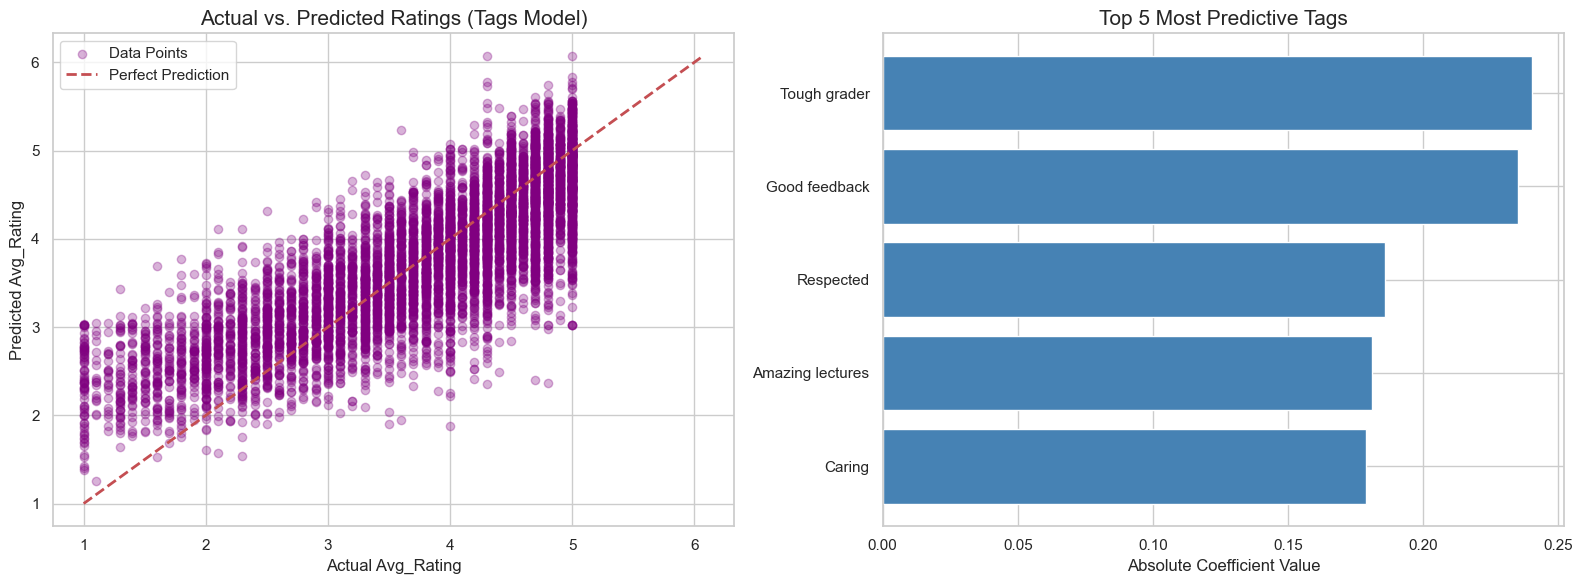

In [29]:
# Visualization for Question 8
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Predicted vs Actual
axes[0].scatter(y_test_tags, y_pred_tags, alpha=0.3, color='purple', label='Data Points')
min_val = min(y_test_tags.min(), y_pred_tags.min())
max_val = max(y_test_tags.max(), y_pred_tags.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_title('Actual vs. Predicted Ratings (Tags Model)', fontsize=15)
axes[0].set_xlabel('Actual Avg_Rating', fontsize=12)
axes[0].set_ylabel('Predicted Avg_Rating', fontsize=12)
axes[0].legend()

# Plot 2: Top 5 most predictive tags (by absolute coefficient)
top_tags = params_tags.abs().nlargest(5)
top_tags_sorted = top_tags.sort_values(ascending=True)
axes[1].barh(range(len(top_tags_sorted)), top_tags_sorted.values, color='steelblue')
axes[1].set_yticks(range(len(top_tags_sorted)))
axes[1].set_yticklabels([tag.replace('_norm', '').replace('_', ' ') for tag in top_tags_sorted.index])
axes[1].set_xlabel('Absolute Coefficient Value', fontsize=12)
axes[1].set_title('Top 5 Most Predictive Tags', fontsize=15)
plt.tight_layout()
plt.show()


Question 9: Build a regression model predicting average difficulty from all tags (the ones in the rmpCapstoneTags.csv) file. Make sure to include the R2 and RMSE of this model. Which of these tags is most strongly predictive of average difficulty? Hint: Make sure to address collinearity concerns.


In [30]:
# Prepare data for difficulty prediction
target_difficulty = 'Avg_Difficulty'

# Merge tags with difficulty data
tags_num_difficulty = tags.merge(num_full[['Avg_Difficulty', 'NumofRatings']], left_index=True, right_index=True)

# Apply same threshold for rating reliability
print(f"Data before filtering: {len(tags_num_difficulty)}")
tags_num_difficulty = tags_num_difficulty[tags_num_difficulty['NumofRatings'] >= MIN_RATINGS_THRESHOLD]
print(f"Data after filtering (>= {MIN_RATINGS_THRESHOLD} ratings): {len(tags_num_difficulty)}")

# Create normalized tag columns (same normalization as before)
for tag in tag_names:
    tags_num_difficulty[f'{tag}_norm'] = tags_num_difficulty[tag] / tags_num_difficulty['NumofRatings'].replace(0, np.nan)

# Prepare regression data
regression_data_difficulty = tags_num_difficulty[tag_predictors + [target_difficulty, 'NumofRatings']].dropna()

print(f"Data for difficulty prediction: {len(regression_data_difficulty)} observations")
print(f"Note: Only using professors with >= {MIN_RATINGS_THRESHOLD} ratings for reliability")

# Build regression model
X_diff = regression_data_difficulty[tag_predictors]
y_diff = regression_data_difficulty[target_difficulty]

# Split data
X_train_diff, X_test_diff, y_train_diff, y_test_diff = train_test_split(
    X_diff, y_diff, test_size=0.2, random_state=MY_SEED
)

# Standardize features
scaler_diff = StandardScaler()
X_train_diff_scaled = scaler_diff.fit_transform(X_train_diff)
X_test_diff_scaled = scaler_diff.transform(X_test_diff)

# Convert back to DataFrame
X_train_diff_scaled = pd.DataFrame(X_train_diff_scaled, columns=tag_predictors, index=X_train_diff.index)
X_test_diff_scaled = pd.DataFrame(X_test_diff_scaled, columns=tag_predictors, index=X_test_diff.index)

# Add constant
X_train_diff_scaled = sm.add_constant(X_train_diff_scaled)
X_test_diff_scaled = sm.add_constant(X_test_diff_scaled)

# Fit OLS model
model_difficulty = sm.OLS(y_train_diff, X_train_diff_scaled).fit()

# Print summary
print(model_difficulty.summary())

# Calculate RMSE and R² on test set
y_pred_diff = model_difficulty.predict(X_test_diff_scaled)
rmse_diff = np.sqrt(mean_squared_error(y_test_diff, y_pred_diff))
r2_test_diff = r2_score(y_test_diff, y_pred_diff)
print(f"\nTest RMSE: {rmse_diff:.4f}")
print(f"Test R-squared: {r2_test_diff:.4f}")
print(f"Training R-squared: {model_difficulty.rsquared:.4f}")

# Find most predictive tag and check significance (α = 0.005)
ALPHA = 0.005
params_diff = model_difficulty.params.drop('const')
pvalues_diff = model_difficulty.pvalues.drop('const')

# Find significant tags
significant_tags_diff = pvalues_diff[pvalues_diff < ALPHA]
print(f"\nSignificant tags (p < {ALPHA}): {len(significant_tags_diff)} out of {len(params_diff)}")

max_impact_tag_diff = params_diff.abs().idxmax()
max_impact_value_diff = params_diff[max_impact_tag_diff]
max_impact_pvalue_diff = pvalues_diff[max_impact_tag_diff]

print(f"\nThe tag with the highest impact on Avg_Difficulty is '{max_impact_tag_diff}'")
print(f"  Coefficient: {max_impact_value_diff:.4f}")
print(f"  P-value: {max_impact_pvalue_diff:.6f}")
print(f"  Significant at α={ALPHA}: {'Yes' if max_impact_pvalue_diff < ALPHA else 'No'}")


Data before filtering: 89893
Data after filtering (>= 3 ratings): 40528
Data for difficulty prediction: 40528 observations
Note: Only using professors with >= 3 ratings for reliability
                            OLS Regression Results                            
Dep. Variable:         Avg_Difficulty   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     1521.
Date:                Thu, 18 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:58:57   Log-Likelihood:                -30047.
No. Observations:               32422   AIC:                         6.014e+04
Df Residuals:                   32401   BIC:                         6.031e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                         

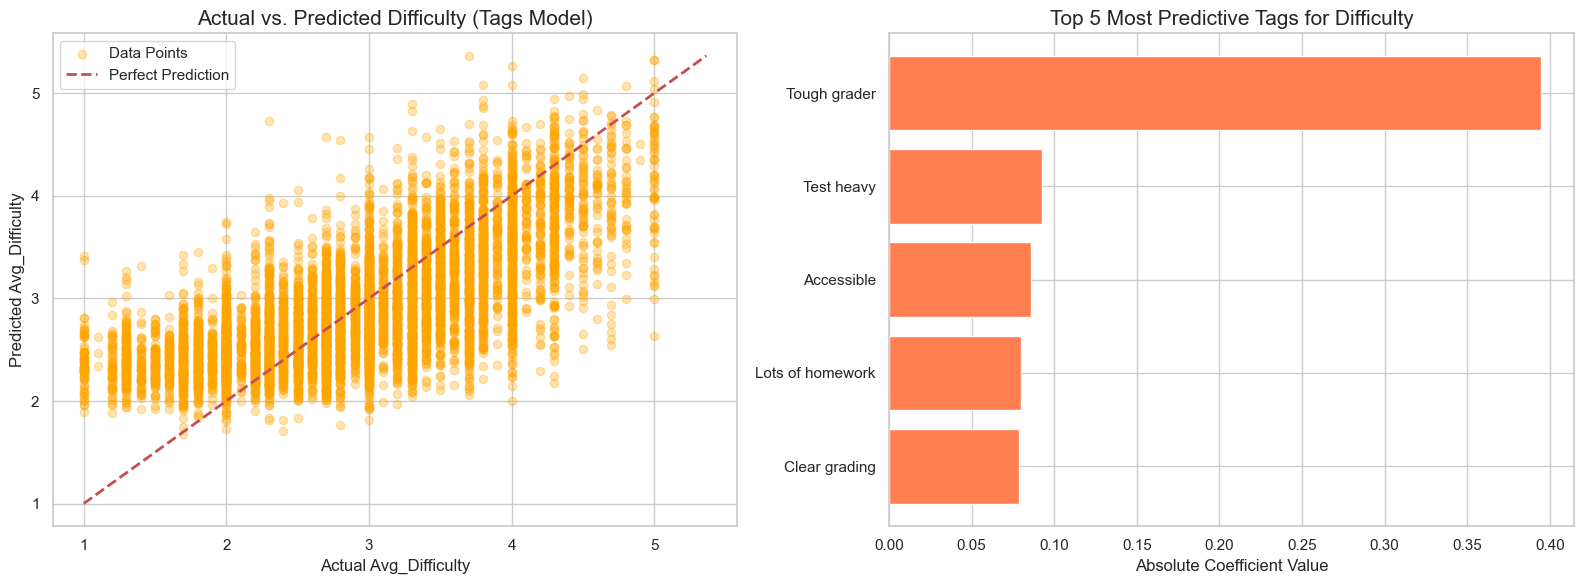

In [31]:
# Visualization for Question 9
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Predicted vs Actual
axes[0].scatter(y_test_diff, y_pred_diff, alpha=0.3, color='orange', label='Data Points')
min_val = min(y_test_diff.min(), y_pred_diff.min())
max_val = max(y_test_diff.max(), y_pred_diff.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_title('Actual vs. Predicted Difficulty (Tags Model)', fontsize=15)
axes[0].set_xlabel('Actual Avg_Difficulty', fontsize=12)
axes[0].set_ylabel('Predicted Avg_Difficulty', fontsize=12)
axes[0].legend()

# Plot 2: Top 5 most predictive tags
top_tags_diff = params_diff.abs().nlargest(5)
top_tags_diff_sorted = top_tags_diff.sort_values(ascending=True)
axes[1].barh(range(len(top_tags_diff_sorted)), top_tags_diff_sorted.values, color='coral')
axes[1].set_yticks(range(len(top_tags_diff_sorted)))
axes[1].set_yticklabels([tag.replace('_norm', '').replace('_', ' ') for tag in top_tags_diff_sorted.index])
axes[1].set_xlabel('Absolute Coefficient Value', fontsize=12)
axes[1].set_title('Top 5 Most Predictive Tags for Difficulty', fontsize=15)
plt.tight_layout()
plt.show()


Question 10: Build a classification model that predicts whether a professor receives a "pepper" from all available factors (both tags and numerical). Make sure to include model quality metrics such as AU(RO)C and also address class imbalance concerns.


In [32]:
# Prepare data for classification
# Merge all data: tags (normalized), numerical features
num_class = num_full.copy()
num_class.columns = ['Avg_Rating', 'Avg_Difficulty', 'NumofRatings', 'Pepper', 'Again?', 'From online', 'Male', 'Female']

# Apply threshold for rating reliability (same as regression models)
print(f"Data before filtering: {len(num_class)}")
num_class = num_class[num_class['NumofRatings'] >= MIN_RATINGS_THRESHOLD]
print(f"Data after filtering (>= {MIN_RATINGS_THRESHOLD} ratings): {len(num_class)}")

# Create Gender column
num_class['Gender'] = num_class['Male'] + num_class['Female'] * -1
num_class['Gender'] = num_class['Gender'].replace(0, pd.NA)
num_class['Gender'] = num_class['Gender'].replace(2, pd.NA)

# Merge tags with numerical data
tags_class = tags.copy()
tags_class.columns = tag_names

# Normalize tags (divide by number of ratings)
for tag in tag_names:
    tags_class[f'{tag}_norm'] = tags_class[tag] / num_class['NumofRatings'].replace(0, np.nan)

# Combine all features
all_features = num_class[['Avg_Rating', 'Avg_Difficulty', 'NumofRatings', 'Again?', 'From online', 'Gender']].copy()
all_features = all_features.merge(tags_class[[f'{tag}_norm' for tag in tag_names]], 
                                   left_index=True, right_index=True)

# Target variable
target_class = num_class['Pepper'].copy()

# Combine and drop missing values
classification_data = all_features.copy()
classification_data['Pepper'] = target_class
classification_data = classification_data.dropna()

print(f"\nClassification data shape: {classification_data.shape}")
print(f"\nClass distribution:")
print(classification_data['Pepper'].value_counts())
print(f"\nClass proportions:")
print(classification_data['Pepper'].value_counts(normalize=True))


Data before filtering: 89893
Data after filtering (>= 3 ratings): 40528

Classification data shape: (8849, 27)

Class distribution:
Pepper
0.0    4683
1.0    4166
Name: count, dtype: int64

Class proportions:
Pepper
0.0    0.529212
1.0    0.470788
Name: proportion, dtype: float64


In [33]:
# Prepare features and target
feature_cols = [col for col in classification_data.columns if col != 'Pepper']
X_class = classification_data[feature_cols]
y_class = classification_data['Pepper'].astype(int)  # Ensure binary

# Split data
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.2, random_state=MY_SEED, stratify=y_class
)

print(f"Training set class distribution:")
print(y_train_class.value_counts())
print(f"\nTest set class distribution:")
print(y_test_class.value_counts())

# Standardize features
scaler_class = StandardScaler()
X_train_class_scaled = scaler_class.fit_transform(X_train_class)
X_test_class_scaled = scaler_class.transform(X_test_class)

# Convert back to DataFrame
X_train_class_scaled = pd.DataFrame(X_train_class_scaled, columns=feature_cols, index=X_train_class.index)
X_test_class_scaled = pd.DataFrame(X_test_class_scaled, columns=feature_cols, index=X_test_class.index)


Training set class distribution:
Pepper
0    3746
1    3333
Name: count, dtype: int64

Test set class distribution:
Pepper
0    937
1    833
Name: count, dtype: int64


In [34]:
# Build Logistic Regression model (with class_weight to handle imbalance)
lr_model = LogisticRegression(random_state=MY_SEED, class_weight='balanced', max_iter=1000)
lr_model.fit(X_train_class_scaled, y_train_class)

# Predictions
y_pred_lr = lr_model.predict(X_test_class_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_class_scaled)[:, 1]

# Calculate metrics
auc_lr = roc_auc_score(y_test_class, y_pred_proba_lr)
print("Logistic Regression Results:")
print(f"AUROC: {auc_lr:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_class, y_pred_lr))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_class, y_pred_lr))

# Feature importance (using absolute coefficients)
lr_feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Abs_Coefficient': np.abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)


Logistic Regression Results:
AUROC: 0.8038

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.68      0.72       937
           1       0.68      0.77      0.72       833

    accuracy                           0.72      1770
   macro avg       0.73      0.73      0.72      1770
weighted avg       0.73      0.72      0.72      1770


Confusion Matrix:
[[634 303]
 [188 645]]


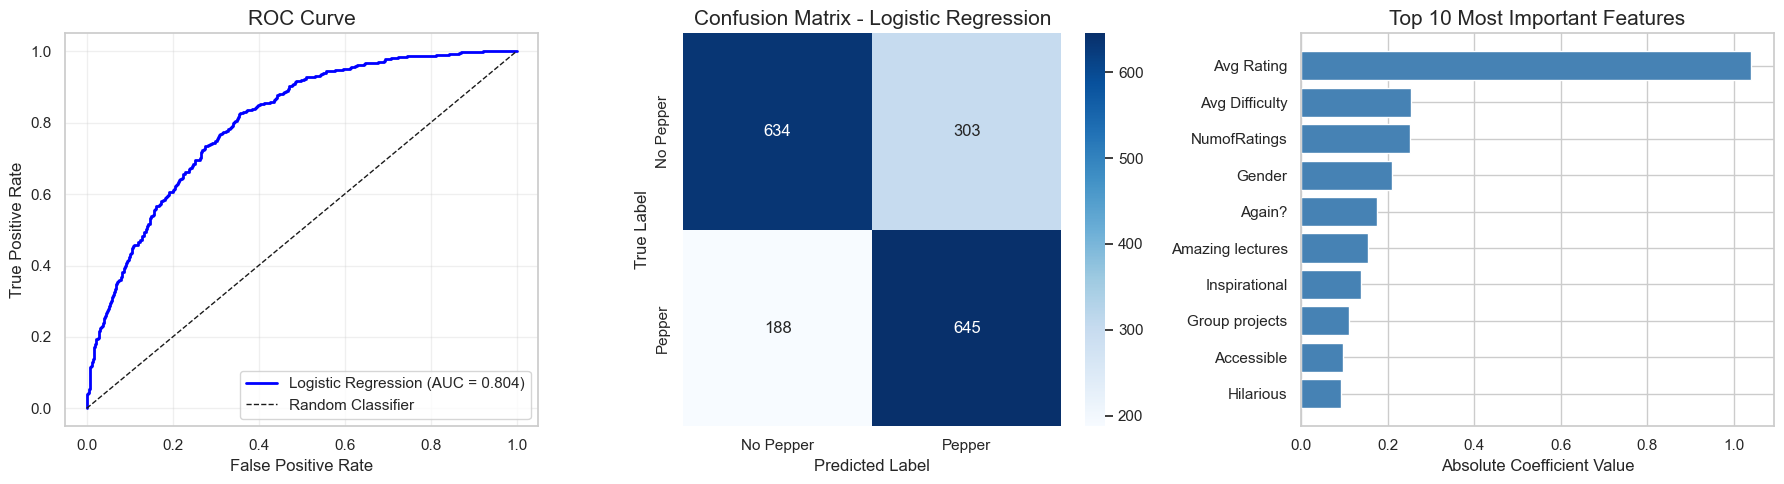


Model Summary:
Logistic Regression AUROC: 0.8038


In [35]:
# Visualization for Question 10
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: ROC Curve for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test_class, y_pred_proba_lr)

axes[0].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})', linewidth=2, color='blue')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve', fontsize=15)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test_class, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[1], 
            xticklabels=['No Pepper', 'Pepper'], yticklabels=['No Pepper', 'Pepper'])
axes[1].set_title('Confusion Matrix - Logistic Regression', fontsize=15)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

# Plot 3: Top 10 Feature Importances (Logistic Regression)
top_10_features_lr = lr_feature_importance.head(10)
axes[2].barh(range(len(top_10_features_lr)), top_10_features_lr['Abs_Coefficient'].values, color='steelblue')
axes[2].set_yticks(range(len(top_10_features_lr)))
axes[2].set_yticklabels([feat.replace('_norm', '').replace('_', ' ') for feat in top_10_features_lr['Feature']])
axes[2].set_xlabel('Absolute Coefficient Value', fontsize=12)
axes[2].set_title('Top 10 Most Important Features', fontsize=15)
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

# Print summary
print(f"\nModel Summary:")
print(f"Logistic Regression AUROC: {auc_lr:.4f}")
